In [1]:
import pandas as pd

# 加载数据
file_path = 'cinema_transactions.csv'
data = pd.read_csv(file_path)
data['not_happened_yet_date'] = pd.to_datetime(data['not_happened_yet_date'], format='%d/%m/%Y')

# 设置日期列为索引
data.set_index('not_happened_yet_date', inplace=True)

# 按天汇总交易额并输出
daily_transactions = data['monopoly_money_amount'].resample('D').sum().reset_index()
daily_transactions.to_csv('cinema_daily_transactions.csv', index=False)

# 提取年份和月份，分组、求和
daily_transactions['year'] = daily_transactions['not_happened_yet_date'].dt.year
daily_transactions['month'] = daily_transactions['not_happened_yet_date'].dt.month
monthly_transactions = daily_transactions.groupby(['year', 'month'])['monopoly_money_amount'].sum().reset_index()
monthly_transactions['year_month'] = monthly_transactions['year'].astype(str) + '-' + monthly_transactions['month'].astype(str).str.zfill(2)
monthly_transactions = monthly_transactions[['year_month', 'monopoly_money_amount']]

# 输出每月交易额
monthly_transactions.to_csv('cinema_monthly_transactions.csv', index=False)

# 按周重新采样并求和
weekly_transactions = data['monopoly_money_amount'].resample('W').sum().reset_index()
# 输出每周交易额

weekly_transactions.to_csv('cinema_weekly_transactions.csv', index=False)
weekly_transactions.head()

,not_happened_yet_date,monopoly_money_amount
0,2025-01-05,5600.0
1,2025-01-12,7800.0
2,2025-01-19,8005.0
3,2025-01-26,7765.0
4,2025-02-02,7319.0


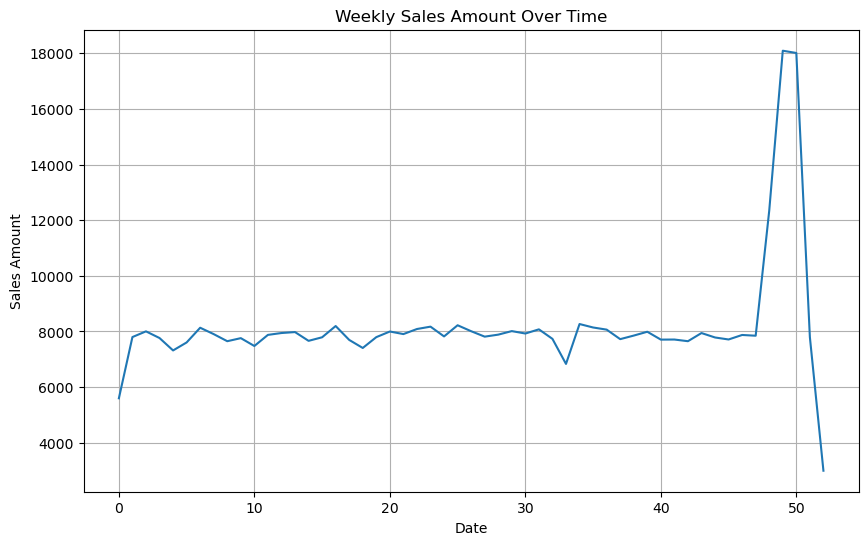

In [2]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# 绘制时间序列图
plt.figure(figsize=(10, 6))
plt.plot(weekly_transactions.index, weekly_transactions['monopoly_money_amount'], linestyle='-', marker=None)
plt.title('Weekly Sales Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.grid(True)
plt.show()

In [3]:
# 进行ADF平稳性检验
adf_test_weekly = adfuller(weekly_transactions['monopoly_money_amount'])

# 输出ADF检验结果
adf_result_weekly = {
    'Test Statistic': adf_test_weekly[0],
    'p-value': adf_test_weekly[1],
    'Used Lag': adf_test_weekly[2],
    'Number of Observations Used': adf_test_weekly[3],
    'Critical Values': adf_test_weekly[4],
}

adf_result_weekly

{'Test Statistic': 1.07091958878564,
 'p-value': 0.994960629384209,
 'Used Lag': 3,
 'Number of Observations Used': 49,
 'Critical Values': {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153}}

Test Statistic和p-value说明时间序列是非平稳的

下面进行一阶差分

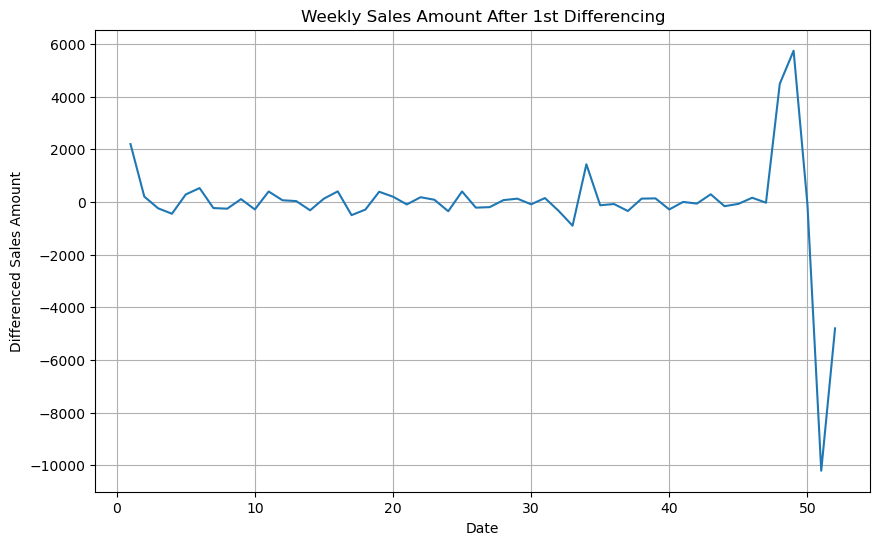

{'Test Statistic': -9.849678744110907,
 'p-value': 4.520593860354101e-17,
 'Used Lag': 1,
 'Number of Observations Used': 50,
 'Critical Values': {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}}

In [4]:
# 进行一阶差分
weekly_sales_diff = weekly_transactions['monopoly_money_amount'].diff().dropna()

# 绘制一阶差分后的时间序列图
plt.figure(figsize=(10, 6))
plt.plot(weekly_sales_diff.index, weekly_sales_diff, linestyle='-', marker=None)
plt.title('Weekly Sales Amount After 1st Differencing')
plt.xlabel('Date')
plt.ylabel('Differenced Sales Amount')
plt.grid(True)
plt.show()

# 再次进行ADF平稳性检验
adf_test_diff = adfuller(weekly_sales_diff)

# 输出ADF检验结果
adf_result_diff = {
    'Test Statistic': adf_test_diff[0],
    'p-value': adf_test_diff[1],
    'Used Lag': adf_test_diff[2],
    'Number of Observations Used': adf_test_diff[3],
    'Critical Values': adf_test_diff[4],
}

adf_result_diff

平稳   d=1

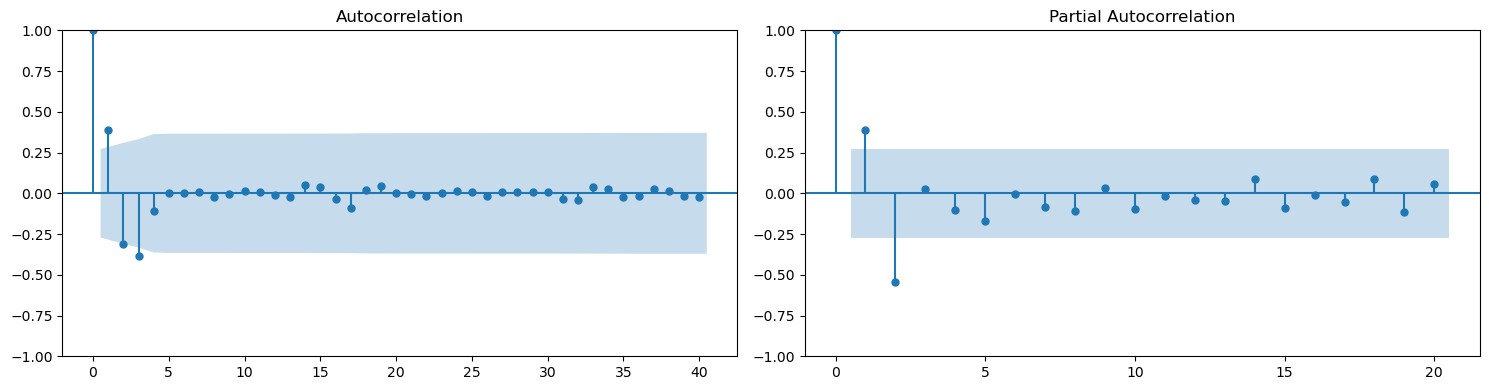

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 绘制ACF和PACF图
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# ACF
plot_acf(weekly_sales_diff, ax=axes[0], lags=40)

# PACF
plot_pacf(weekly_sales_diff, ax=axes[1], lags=20)

plt.tight_layout()
plt.show()


ACF图显示在初期滞后阶数上的显著自相关性，这随着滞后数的增加而逐渐减弱。
PACF图在几个初期滞后阶数上显示了显著的峰值，尤其是第一和二滞后阶数。
因此先假设p=q=1

假设以月为周期，近似为4周，则s=4



In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 定义模型参数
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 4  # 季节周期设定为4，假设每个月有大约4周

# 拟合SARIMA模型
model_weekly = SARIMAX(weekly_transactions['monopoly_money_amount'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_weekly = model_weekly.fit()

# 打印模型摘要
model_fit_weekly.summary()

D:\app\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:             monopoly_money_amount   No. Observations:                   53
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -423.194
Date:                           Thu, 22 Feb 2024   AIC                            856.388
Time:                                   00:41:12   BIC                            865.744
Sample:                                        0   HQIC                           859.923
                                            - 53                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1125      0.245      0.460      0.646      -0.367       0.592
ma.L1          0.7683      0.250      3.068      0.002       0.278       1.259
ar.S.L4        0.2738      1.466      0.187      0.852      -2.599       3.147
ma.S.L4       -0.6521      1.539     -0.424      0.672      -3.668       2.364
sigma2      2.541e+06   3.36e+05      7.571      0.000    1.88e+06     3.2e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               453.29
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              21.35   Skew:                            -2.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

自回归系数AR=0.1125，自回归项对模型的贡献相对较小。

移动平均系数MA=0.7683，表示前一期的误差对当前值有较大影响。

季节性自回归系数AR.S=0.2738，标准误较大，但存在一定的季节性自回归效应。

季节性移动平均系数MA.S=-0.6520，即季节性误差对当前值的影响。


In [7]:
# 定义模型参数
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 4  # 季节周期设定为4，假设每个月有大约4周

# 拟合SARIMA模型
model_weekly = SARIMAX(weekly_transactions['monopoly_money_amount'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_weekly = model_weekly.fit()

# 打印模型摘要
model_fit_weekly.summary()

D:\app\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
D:\app\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               monopoly_money_amount   No. Observations:                   53
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 4)   Log Likelihood                -410.971
Date:                             Thu, 22 Feb 2024   AIC                            835.942
Time:                                     00:41:14   BIC                            849.040
Sample:                                          0   HQIC                           840.892
                                              - 53                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7268      0.321      2.265      0.023       0.098       1.356
ar.L2         -1.0000      0.332     -3.011      0.003      -1.651      -0.349
ma.L1         -0.0467      0.340     -0.137      0.891      -0.713       0.620
ma.L2          0.0025      0.656      0.004      0.997      -1.282       1.287
ar.S.L4        0.0431      0.667      0.065      0.949      -1.264       1.350
ma.S.L4       -0.6452      0.660     -0.978      0.328      -1.938       0.648
sigma2      1.566e+06   2.55e+05      6.136      0.000    1.07e+06    2.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.90
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.01   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

gpt：
您提供的SARIMA模型结果是基于p=2, d=1, q=2以及季节性参数P=1, D=1, Q=1和季节周期s=4。下面是对这个模型结果的分析：

模型参数
AR参数 (ar.L1和ar.L2)：第一个AR参数显著（系数为0.7268），第二个AR参数也显著且系数为-1.0000。这表明时间序列的当前值与其前两个值有显著的线性关系。
MA参数 (ma.L1和ma.L2)：MA参数不显著，P值远大于0.05，这可能意味着这些参数对模型的贡献有限。
季节性AR和MA参数 (ar.S.L4和ma.S.L4)：同样，这些季节性参数的系数并不显著，P值很高。
模型评价指标
Log Likelihood：-410.971，模型对数据的拟合程度。
AIC：835.942，较之前的模型（AIC为856.388）有所降低，表明模型的相对质量有所提高。
BIC：849.040，同样比之前的模型（BIC为865.744）降低，指出在考虑模型复杂度后，模型的整体效果有所提升。
统计检验
Ljung-Box Test：Prob(Q)值为0.99，表明模型残差序列是随机的，无自相关性。
Jarque-Bera Test：Prob(JB)值接近0，表明残差不服从正态分布，存在67.90的值表明残差分布的偏度和峰度与正态分布相比有显著差异。
Heteroskedasticity Test：Prob(H)值为0.00，表明模型存在异方差性。
分析结论
改进的模型（使用p=q=2）在AIC和BIC上显示出比之前的模型更好的相对效果，但仍然存在一些问题，如残差的非正态性和异方差性。
MA参数和季节性参数不显著，可能意味着这些参数对模型的改进不大。进一步的模型简化或调整可能是必要的。
统计检验结果表明，虽然残差无自相关性，但残差的分布特性和方差稳定性仍然是模型优化的潜在问题区域。
在实际应用中，可能需要进一步的诊断和尝试不同的模型配置，以找到最佳的模型参数组合。此外，考虑到残差的非正态性和异方差性，可能需要对数据进行变换或考虑使用具有更复杂误差结构的模型。